# 부스팅이란

부스팅 알고리즘은 여러 개의 약한 학습기(weak learner)를 순차적으로 학습-예측하면서  
잘못 예측한 데이터에 가중치를 부여해 오류를 개선해나가며 학습하는 방식
부스팅 알고리즘은 대표적으로 아래와 같은 알고리즘들이 있음

- AdaBoost
- Gradient Booting Machine(GBM)
- XGBoost
- LightGBM
- CatBoost

___
# 에이다 부스트 (AdaBoost)

Adaptive Boost의 줄임말로서 약한 학습기(weak learner)의 오류 데이터에  
가중치를 부여하면서 부스팅을 수행하는 대표적인 알고리즘  
속도나 성능적인 측면에서 decision tree를 약한 학습기로 사용함

## 에이다 부스트의 학습

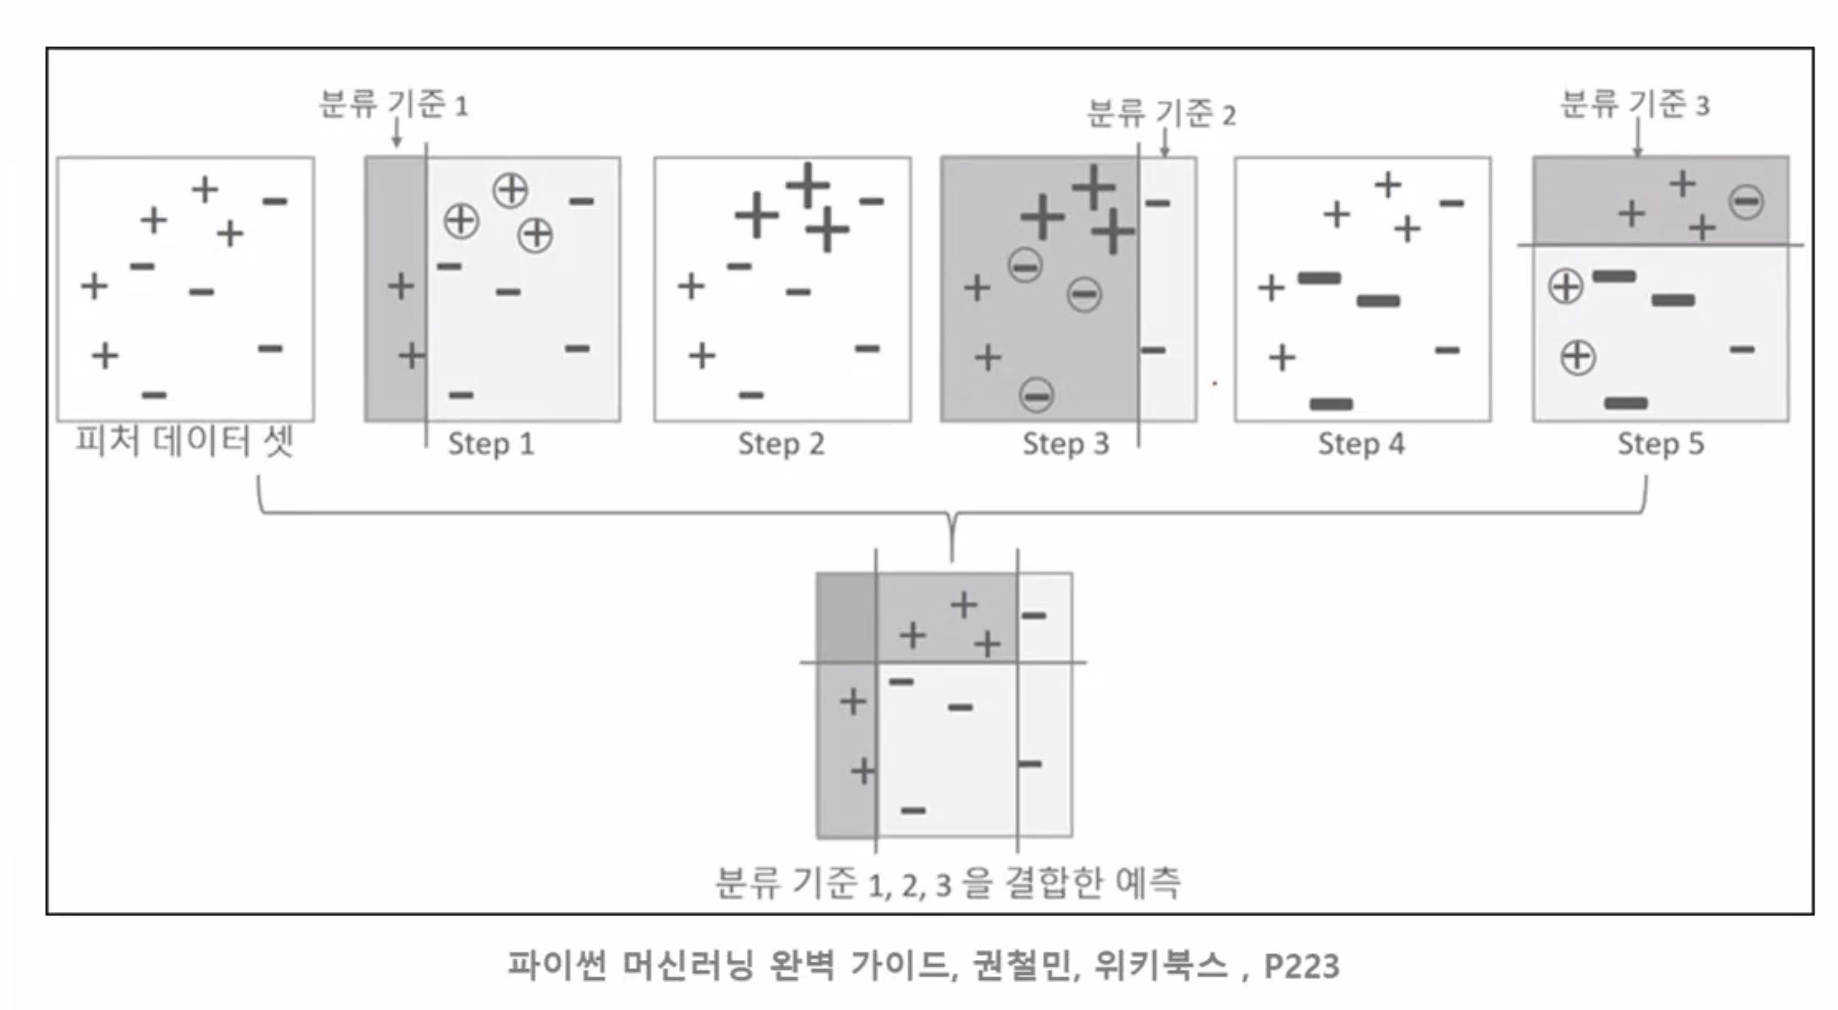

- Step 1) 첫 번째 약한 학습기가 첫번째 분류기준 1로 + 와 - 를 분류 (+는 잘못 분류된 오류)  
- Step 2) 잘못 분류된 데이터에 대해 가중치를 부여(두 번쨰 그림에서 커진 + 표시)  
- Step 3) 두 번째 약한 학습기가 두번째 분류기준 2로 +와 - 를 다시 분류 (-는 잘못 분류된 오류)  
- Step 4) 잘못 분류된 데이터에 대해 가중치를 부여(세 번째 그림에서 커진 - 표시)  
- Step 5) 세 번째 약한 학습기가 세번째 분류기준 3으로 +와 -를 다시 분류해서 오류 데이터를 찾음  
- Step 6) 마지막으로 분류기들을 결합하여 최종 예측 수행  
  
→ 약한 학습기를 순차적으로 학습시켜, 개별 학습기에 가중치를 부여하여 모두 결합함으로써  
  개별 약한 학습기보다 높은 정확도의 예측 결과를 만듦

___
# 그래디언트 부스트 (GBM)

GBM은 AdaBoost와 유사하지만, 가중치 업데이트를 경사하강법(Gradient Descent)를 이용하여  
최적화된 결과를 얻는 알고리즘이다. 오류값은 실제값 - 예측값이다.   
GBM은 예측 성능이 높지만 Greedy Algorithm으로 과적합이 빠르게되고, 시간이 오래 걸린다는 단점이 있다.  
분류와 회귀 둘다 사용가능하다.  
  
**※ 경사하강법**  
분류의 실제값을 y, 피처에 기반한 예측함수를 F(x), 오류식을 h(x) = y-F(x)라고 하면  
이 오류식을 최소화하는 방향성을 가지고 가중치 값을 업데이트  

## GBM 예제
사이킷런의 GBM을 이용해 사용자 행동 데이터 세트 예측 분류하기  
앞 랜덤 포레스트에서 작성한 get_human_dataset() 함수 가져오기  

In [5]:
# 피처명 변경해서 반환하는 과정을 함수로 작성
# 피처명_1 또는 피처명_2로 변경


def get_new_feature_name_df(old_feature_name_df):
    # gruopby('column_name').cumcount() : 중복되는 값이 몇 번째에 해당되는지 index로 반환
    # 0이면 첫 번째, 1이면 두 번째...
    feature_dup_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(), columns=['dup_cnt'])
    
    # merge() 하기 위해 index 값을 갖는 열 필요
    # reset_index() : index를 열로 변환
    feature_dup_df = feature_dup_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(), feature_dup_df, how='outer')
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name', 'dup_cnt']].apply(lambda x : x[0]+'_'+str(x[1]) 
                                                                                           if x[1] >0 else x[0], axis=1)
    new_feature_name_df = new_feature_name_df.drop(['index'], axis=1)
    return new_feature_name_df

In [6]:
# get_human_dataset 데이터 세트 가져오기

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split

import warnings
warnings.filterwarnings('ignore')

def get_human_dataset( ):
    
    # 각 데이터 파일들은 공백으로 분리되어 있으므로 read_csv에서 공백 문자를 sep으로 할당.
    feature_name_df = pd.read_csv('data/human_activity/features.txt',sep='\s+',
                        header=None,names=['column_index','column_name'])
    
    # 중복된 feature명을 새롭게 수정하는 get_new_feature_name_df()를 이용하여 새로운 feature명 DataFrame생성. 
    new_feature_name_df = get_new_feature_name_df(feature_name_df)
    
    # DataFrame에 피처명을 컬럼으로 부여하기 위해 리스트 객체로 다시 변환
    feature_name = new_feature_name_df.iloc[:, 1].values.tolist()
    
    # 학습 피처 데이터 셋과 테스트 피처 데이터을 DataFrame으로 로딩. 컬럼명은 feature_name 적용
    X_train = pd.read_csv('data/human_activity/train/X_train.txt',sep='\s+', names=feature_name )
    X_test = pd.read_csv('data/human_activity/test/X_test.txt',sep='\s+', names=feature_name)
    
    # 학습 레이블과 테스트 레이블 데이터을 DataFrame으로 로딩하고 컬럼명은 action으로 부여
    y_train = pd.read_csv('data/human_activity/train/y_train.txt',sep='\s+',header=None,names=['action'])
    y_test = pd.read_csv('data/human_activity/test/y_test.txt',sep='\s+',header=None,names=['action'])
    
    # 로드된 학습/테스트용 DataFrame을 모두 반환 
    return X_train, X_test, y_train, y_test

X_train, X_test, y_train, y_test = get_human_dataset()

In [8]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score
import time
import warnings
warnings.filterwarnings('ignore')

X_train, X_test, y_train, y_test = get_human_dataset()

# GBM 수행 시간 측정 : 시작 시간 설정
start_time = time.time()

gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train, y_train)
gb_pred = gb_clf.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)

print('GBM 정확도 : {0:.4f}'.format(gb_accuracy))
print('GBM 수행 시간 : (0:.1f)초'.format(time.time() - start_time))

GBM 정확도 : 0.9393
GBM 수행 시간 : (0:.1f)초


**결과**  
기본 하이퍼 파라미터만으로도 %의 예측 정확도로  
앞의 튜닝된 하이퍼 파라미터로 재학습 및 예측/평가한 랜덤 포레스트 (91.65%)보다 나은 예측 성능을 나타냄  
  
일반적으로 GBM이 랜덤 포레스트보다 예측 성능이 조금 뛰어난 경우가 많음  
문제는 시간 오래 걸리고 하이퍼 파라미터 튜닝 노력도 더 필요함   
수행 시간은 GBM이 극복해야 할 중요한 과제임    
사이킷런의 GradientBoostingClassifier는 약한 학습기의 순차적인 예측 오류 보정을 통해 학습을 수행하므로  
멀티 CPU 코어 시스템을 사용하더라도 병렬 처리가 지원되지 않아서 대용량 데이터의 경우 학습에 매우 많은 시간이 필요  
  
데이터가 커지만 커질수록 너무 오래 걸려서 하이퍼 파라미터 튜닝하기 많이 어려움  
반면에 랜덤포레스트 같은 경우 상대적으로 빠른 수행 시간을 보장해주기 때문에  
더 쉽게 예측 결과를 도출 할 수 있음  

___
# GBM의 하이퍼파라미터
GBM 하이퍼 파라미터 및 튜닝

## Tree에 관한 하이퍼 파라미터


파라미터 명 | 설명
:----:|:----
  max_depth   | - 트리의 최대 깊이<br>- default = 3<br>- 깊이가 깊어지면 과적합될 수 있으므로 적절히 제어 필요
         min_samples_split          | - 노드를 분할하기 위한 최소한의 샘플 데이터수<br>→ 과적합을 제어하는데 사용<br>- Default = 2 <br>→ 작게 설정할 수록 분할 노드가 많아져 과적합 가능성 증가
min_samples_leaf	| - 리프노드가 되기 위해 필요한 최소한의 샘플 데이터수<br>- min_samples_split과 함께 과적합 제어 용도<br>- default = 1<br>- 불균형 데이터의 경우 특정 클래스의 데이터가 극도로 작을 수 있으므로 작게 설정 필요
max_features | - 최적의 분할을 위해 고려할 최대 feature 개수<br>- Default = 'none' → 모든 피처 사용<br>- int형으로 지정 →피처 갯수 / float형으로 지정 →비중<br>- sqrt 또는 auto : 전체 피처 중 √(피처개수) 만큼 선정<br>- log : 전체 피처 중 log2(전체 피처 개수) 만큼 선정
max_leaf_nodes | - 리프노드의 최대 개수<br>- default = None → 제한없음


파라미터 명	설명
loss	- 경사하강법에서 사용할 cost function 지정
- 특별한 이유가 없으면 default 값인 deviance 적용
n_estimators	- 생성할 트리의 갯수를 지정
- Default = 100
- 많을소록 성능은 좋아지지만 시간이 오래 걸림
learning_rate	- 학습을 진행할 때마다 적용하는 학습률(0~1)
- Weak learner가 순차적으로 오류 값을 보정해나갈 때 적용하는 계수
- Default = 0.1
- 낮은 만큼 최소 오류 값을 찾아 예측성능이 높아질 수 있음
- 하지만 많은 수의 트리가 필요하고 시간이 많이 소요
subsample	- 개별 트리가 학습에 사용하는 데이터 샘플링 비율(0~1)
- default=1 (전체 데이터 학습)
- 이 값을 조절하여 트리 간의 상관도를 줄일 수 있음

loss : 경사 하강법에서 사용할 비용 함수 지정. 기본값은 'deviance'
    
n_estimators : weak learner의 개수. 기본갑 100
- weak learner가 순차적으로 오류를 보정하므로
- 개수가 많을수록 예측 성능이 일정 수준까지 좋아질 수 있음
- 그러나 개수가 많을 수록 시간이 오래 걸림

learning_rate : GBM이 학습을 진행할 때마다 적용하는 학습률
- weak learner가 순차적으로 오류값을 보정해 나가는 데 적용하는 계수
- 0 ~ 1 사이의 값 지정 (기본값 0.1)
- 작은 값을 적용하면 업데이트 되는 값이 작아져서
- 최소 오류 값을 찾아 예측 성능이 높아질 가능성은 높지만
- 많은 weak learner의 순차적인 반복 작업에 수행 시간이 올래 걸림
- 너무 작게 설정하면 모든 weak learner의 반복이 완료돼도
- 최소 오류값을 찾지 못할 수도 있음
- 반대로 큰 값을 적용하면 
- 최소 오류값을 찾지 못하고 그냥 지차져 버려
- 예측 성능이 떨어질 가능성이 높아지지만
- 빠른 수행은 가능

subsample : weak learner가 학습에 사용하는 데이터의 샘플링 비율
- 기본값 1 : 전체 학습 데이터를 기반으로 학습한다는 의미
- 0.5 : 학습 데이터의 50%
- 과적합이 염려되는 경우 1보다 작은 값으로 설정

## GridSearchCV를 통한 GBM의 하이퍼파라미터 튜닝

In [ ]:
from sklearn.model_selection import GridSearchCV

param = {
    'n_estimators' : [100, 500],
    'learning_rate' : [0.05, 0.1]
}

grid_cv = GridSearchCV(gb_clf, param_grid=param, cv=2, verbose=1, n_jobs=-1)
grid_cv.fit(X_train, y_train.values)
print('최적 하이퍼 파라미터: \n', grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

# 실행시간이 30~1시간 30분 정도 소요됨
# learning_rate이 0.05, n_estimators가 500일때
# 2개의 교차 검증 세트에서 90.1%의 최고 예측 정확도 도출

Fitting 2 folds for each of 4 candidates, totalling 8 fits


In [ ]:
scores_df = pd.DataFrame(grid_cv.cv_results_)
scores_df[['params', 'mean_test_score', 'rank_test_score', 'split0_test_score', 'split1_test_score']]

In [ ]:
# GridSearchCV를 이용해 최적으로 학습된 estimators로 예측 수행
# 테스트 데이터 세트에 적용해서 예측 수행

gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test, gb_pred)
print('GBM 정확도: {0:.4f}'.format(gb_accuracy))

# 결과
# 테스트 데이터에서 약 96.06% 정확도 도출

GBM은 수행 시간이 오래 걸린다는 단점이 있지만 과적합에도 강해서 예측 성능이 뛰어난 알고리즘  
많은 알고리즘이 GBM을 기반으로 해서 새롭게 만들어 지고 있음  
  
머신러닝 세계에서 가장 각광받는 그래디언트 부스팅 기반 ML 패키지
- XGBoost
- LightGBM
  
이어서 XGBoost를 배워보자